In [1]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    CropForeground,
    NormalizeIntensity
)
from monai.data import NibabelReader
from monai.networks.blocks import ResidualUnit,Convolution
from torch import nn
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
from IPython import display
import random
import numpy as np

#  Seminar 6.2 : Deep Learning methods for fMRI data

In the seminar we try to implement 3D CNN+GRU model on ICA fMRI data to classify Schizophrenia vs Control on SchizConnect dataset.

fMRI data is 4D tensor with 3 spatial dimensions and one temporal. In last part of seminar we selected 30 ICA components from fMRI data.

Data from SchizConnect was preproccesed by fmriprep

Useful links:


*   Monai docs: https://docs.monai.io/en/latest/api.html
*   SchizConnect: http://schizconnect.org/
*   fMRIPrep : https://fmriprep.org/en/stable/index.html



In [4]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/NEUROML")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
device

device(type='cuda')

Firstly, we need to download preprecessed fMRI data:

In [6]:
! wget "https://s101sas.storage.yandex.net/rdisk/0a856c33bf6fbd84429689663c315247cdb7fe50f0e33984767fadb6c4132045/633618bb/dZndx-jD4XV2UOupXkjAg5iEFaT4yhAfGRDTw4nBc7wG_TERhrAeNyAX_Cq10tnhbjl0twmYuYzASZfIxuYpJA==?uid=0&filename=cobre.zip&disposition=attachment&hash=jCWWei%2Bfei3Sq7nhcjBXsnAClEAC48p18YrBNaN7Q8E8PWGk2CQjN/oYsPfn5Nnvq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=222635455&fsize=17790506046&hid=f8c4b0ea13a37fe1fe3a49c8353e87f3&media_type=compressed&tknv=v2&rtoken=B1DCafoW5pIV&force_default=no&ycrid=na-6b7e9eb9609fc48ad454128615b31bb2-downloader9h&ts=5e9d832db64c0&s=e5cbc8f7eda8e40ef04579a42863d5a1fb88658279a8d34263c72565c5f58edf&pb=U2FsdGVkX19AUKt6DwGHOQSACl2ZPIWjE3GZFW5KV4xPAfNDIWeUAoF2Oux53qOVYVT4QVnTD2L7taQ65FAUbOT4ALNN3CyDkMEMDq8UdRo"

The name is too long, 665 chars total.
Trying to shorten...
New name is dZndx-jD4XV2UOupXkjAg5iEFaT4yhAfGRDTw4nBc7wG_TERhrAeNyAX_Cq10tnhbjl0twmYuYzASZfIxuYpJA==?uid=0&filename=cobre.zip&disposition=attachment&hash=jCWWei+fei3Sq7nhcjBXsnAClEAC48p18YrBNaN7Q8E8PWGk2CQjN%2FoYsPfn5Nnvq%2FJ6bpmRyOJonT3VoXnDag==&l.
--2022-09-29 18:57:13--  https://s101sas.storage.yandex.net/rdisk/0a856c33bf6fbd84429689663c315247cdb7fe50f0e33984767fadb6c4132045/633618bb/dZndx-jD4XV2UOupXkjAg5iEFaT4yhAfGRDTw4nBc7wG_TERhrAeNyAX_Cq10tnhbjl0twmYuYzASZfIxuYpJA==?uid=0&filename=cobre.zip&disposition=attachment&hash=jCWWei%2Bfei3Sq7nhcjBXsnAClEAC48p18YrBNaN7Q8E8PWGk2CQjN/oYsPfn5Nnvq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=222635455&fsize=17790506046&hid=f8c4b0ea13a37fe1fe3a49c8353e87f3&media_type=compressed&tknv=v2&rtoken=B1DCafoW5pIV&force_default=no&ycrid=na-6b7e9eb9609fc48ad454128615b31bb2-downloader9h&ts=5e9d832db64c0&s=e5cbc8f7eda8e40ef04579a42863d5a1fb88658279a8d34263c72565c5

In [7]:
os.rename('dZndx-jD4XV2UOupXkjAg5iEFaT4yhAfGRDTw4nBc7wG_TERhrAeNyAX_Cq10tnhbjl0twmYuYzASZfIxuYpJA==?uid=0&filename=cobre.zip&disposition=attachment&hash=jCWWei+fei3Sq7nhcjBXsnAClEAC48p18YrBNaN7Q8E8PWGk2CQjN%2FoYsPfn5Nnvq%2FJ6bpmRyOJonT3VoXnDag==&l', 'COBRE_ICA_cleaned.zip')

In [8]:
data_path ='COBRE_ICA_cleaned/'
os.mkdir(data_path)

In [113]:
import zipfile
count_files =130
with zipfile.ZipFile(f"COBRE_ICA_cleaned.zip", "a") as z:
   for file in z.namelist():
      if 'fmri.nii' in file:
        count_files-=1
      if count_files>0:  
        z.extract(file, "COBRE_ICA_cleaned")

In [19]:
# import shutil
# shutil.copytree("COBRE_ICA_cleaned", AUX_DATA_ROOT /'data/COBRE_ICA_cleaned2')

## 1. Load Nifty fMRI data with MONAI Datasets

In [5]:
data_path ='COBRE_ICA_cleaned/COBRE_ICA_cleaned'
label_path =AUX_DATA_ROOT / "data/meta_data.tsv"
data_fmriprep_path =Path(data_path)

In [6]:
labels_data =pd.read_csv(label_path, delimiter="\t")
labels_data=labels_data.loc[labels_data['Dx'].isin(['No_Known_Disorder', 'Schizophrenia_Strict'])]
labels_data=labels_data[['Subjectid','Dx']].drop_duplicates()
labels_data['Dx']=labels_data['Dx'].map({'No_Known_Disorder': 0, 'Schizophrenia_Strict' :1})

In [7]:
images =[]
labels =[]
for raw in labels_data.iterrows():
        subj_id=raw[1]['Subjectid']
        label=raw[1]['Dx']
        brain_path =Path(f'{data_path}/sub-{subj_id}/fmri.nii')
        if brain_path.exists():
            images.append(brain_path)
            labels.append(label)

In [8]:
len(labels)

118

In [9]:
np.mean(labels)

0.4745762711864407

In [10]:
labels = torch.nn.functional.one_hot(torch.as_tensor(labels)).float()

In [14]:
# Define transforms
train_transforms = Compose([EnsureChannelFirst(),CropForeground(select_fn=lambda x: x > 0, margin=0),NormalizeIntensity(), Resize((32, 32, 32))])

val_transforms = Compose([EnsureChannelFirst(),CropForeground(select_fn=lambda x: x > 0, margin=0),NormalizeIntensity(), Resize((32, 32, 32))])

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2, num_workers=2, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

# create a training data loader
train_ds = ImageDataset(image_files=images[:-30], labels=labels[:-30], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-30:], labels=labels[-30:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=16, pin_memory=pin_memory)

<class 'monai.data.meta_tensor.MetaTensor'> (2, 30, 32, 32, 32) tensor([[0., 1.],
        [0., 1.]]) torch.Size([2, 2])


In [15]:
example =next(iter(train_loader))

In [16]:
def show_slices(image, axis1="x", axis2="y", axis3="z"):
    slice_0 = image[round(len(image[0])/2), :, :]
    slice_1 = image[:, round(len(image[1])/2), :]
    slice_2 = image[:, :, round(len(image[2])/2)]
    image = ([slice_0, slice_1, slice_2])
    fig, axes = plt.subplots(1, len(image), figsize=[15,15])
    for i, slice in enumerate(image):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[0].set(xlabel=axis2, ylabel=axis3)
        axes[1].set(xlabel=axis1, ylabel=axis3)
        axes[2].set(xlabel=axis1, ylabel=axis2)
    plt.show()

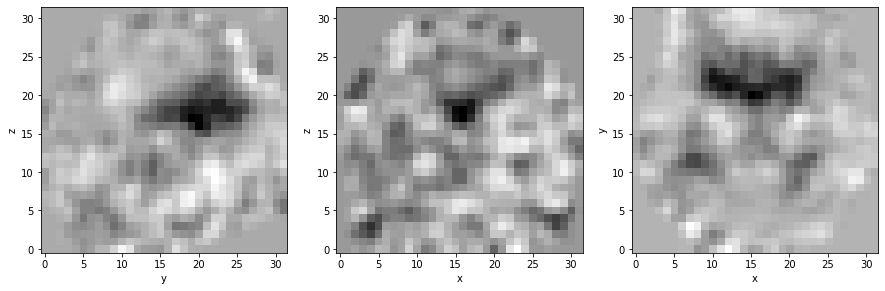

In [17]:
show_slices(example[0][0][0])

## 2. Create 3D CNN+GRU for classify Schizophrenia vs Control

In [18]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class ConvEncoder(nn.Module):
    def __init__(self, in_channels=1,
                 out_channels_list=[32, 64, 128, 256],
                 network_type ='Conv',
                 act ="prelu",
                 norm= "batch",
                 input_shape=(64, 64, 64),
                 is_rcnn=False):
        super(ConvEncoder, self).__init__()
        self.is_rcnn =is_rcnn
        convs =[]
        for out_channels in out_channels_list:
            if network_type =="Residual":
                conv = ResidualUnit(
                        spatial_dims=3,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        act=act,
                        norm=norm,
                        kernel_size=2,
                        strides =1,
                        padding=1
                )
                conv.add_module("maxpool", torch.nn.MaxPool3d(kernel_size=2))
            else:
                conv = Convolution(
                        spatial_dims=3,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        act=act,
                        norm=norm,
                        kernel_size=2,
                        strides =1,
                        padding=1
                )
                conv.add_module("maxpool", torch.nn.MaxPool3d(kernel_size=2))
            in_channels =out_channels
            convs.append(conv)
            
        self.conv_layer =nn.Sequential(*convs)
        input_shape = np.array(input_shape)
        self.n_flatten_units = int(np.prod(input_shape // (2 ** len(out_channels_list))) * out_channels)
        self.faltten = Flatten()
        
    def forward(self, x):
        if self.is_rcnn:
            n_objects, seq_length = x.size()[0:2]
            x = x.reshape([n_objects * seq_length] + list(x.size()[2:]))
            x = torch.unsqueeze(x, axis=1)
            x = self.conv_layer(x)
            x =self.faltten(x)
            x = x.reshape([n_objects, seq_length, -1])
        else:
            x = self.conv_layer(x)
            x =self.faltten(x)
        return x        

In [19]:
class ClfGRU(nn.Module):
    def __init__(self, n_latent_units, seq_length, 
                 hidden_size=128, n_layers=1,
                use_states="last"):
        super(self.__class__, self).__init__()
        self.n_latent_units = n_latent_units
        self.seq_length = seq_length
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(
            n_latent_units, 
            hidden_size, n_layers, 
            batch_first=True
        )
        
        self.use_states = use_states
        if use_states == "last":
            self.gru_out_size = hidden_size
        elif use_states == "mean":
            self.gru_out_size = hidden_size
        elif use_states == "all":
            self.gru_out_size = hidden_size * seq_length
            
    def forward(self, x):
        out, _ = self.gru(x)
        
        if self.use_states == "last":
            out = out[:, -1, :]
        elif self.use_states == "mean":
            out = out.mean(dim=1)
        elif self.use_states == "all":
            out = out.reshape(n_objects, self.hidden_size * seq_length)
        
        return out

In [20]:
class FMRINET(nn.Module):
    def __init__(self, in_channels=10,
                 out_channels_list=[32, 64, 128, 256],
                 network_type ='Conv',
                 act ="relu",
                 norm= "batch",
                 input_shape=(64, 64, 64),
                 n_outputs =2,
                 n_fc_units=128,
                 hidden_size=128,
                 dropout =0.2,
                 n_layers=1,
                 is_rcnn=False):
        super(FMRINET, self).__init__()
        self.is_rcnn=is_rcnn
        if self.is_rcnn:
            self.cnn =ConvEncoder(in_channels=1,
                                    out_channels_list=out_channels_list,
                                    network_type =network_type,
                                    act =act,
                                    norm= norm,
                                    input_shape=input_shape,
                                    is_rcnn=True)
            self.gru =ClfGRU(self.cnn.n_flatten_units, 
                             in_channels,hidden_size=hidden_size,n_layers=n_layers)
            self.fc =nn.Sequential(
                               nn.Dropout(dropout),
                               nn.Linear(self.gru.gru_out_size, n_fc_units),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_outputs))
            
        else:
            self.cnn =ConvEncoder(in_channels=in_channels,
                                    out_channels_list=out_channels_list,
                                    network_type =network_type,
                                    act =act,
                                    norm= norm,
                                    input_shape=input_shape,
                                    is_rcnn=False)
            self.fc =nn.Sequential(
                              #  nn.Dropout(dropout),
                               nn.Linear(self.cnn.n_flatten_units, n_fc_units),
                               nn.ReLU(inplace=True),
                               nn.Linear(n_fc_units, n_outputs))
        
    def forward(self,x):
        if self.is_rcnn:
            x =self.cnn(x)
            x =self.gru(x)
            x =self.fc(x)
        else:
            x =self.cnn(x)
            x =self.fc(x)
        return x    

In [21]:
model =FMRINET( out_channels_list=[8, 16, 32, 64],
                 in_channels=30,
                 n_fc_units=64,
                 hidden_size=64,
                 input_shape=(32, 32, 32),
                 dropout =0.1,is_rcnn=True)

In [22]:
model.cnn.n_flatten_units

512

In [23]:
model=model.to(device)

In [24]:

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [25]:
def plot_loss_and_accuracy(loss_history, train_accuracy, val_accuracy, clear_output=True):
    if clear_output:
        display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    if loss_history:
        ax[0].semilogy(loss_history)
        ax[0].set_title('Training loss')
        ax[0].set_xlabel('# batches processed')
        ax[0].set_ylabel('loss value')
    
    if len(train_accuracy) > 0:
        ax[1].plot(train_accuracy, '*-b', label='train')
        ax[1].plot(val_accuracy, '*-r', label='test')
        ax[1].set_title('Accuracy')
        ax[1].legend()
        ax[1].set_xlabel('# epochs processed')
        ax[1].set_ylabel('accuracy value')
    
    plt.show()

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

In [ ]:
 # start a typical PyTorch training
val_interval = 1
best_metric = -1
best_metric_epoch = -1  
train_loss_values, val_loss_values, train_accuracies, val_accuracies = [],[],[],[]
writer = SummaryWriter()
max_epochs = 6

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    train_loss,val_loss = 0, 0
    step = 0

    num_correct = 0.0
    metric_count = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        
        value = torch.eq(outputs.argmax(dim=1), labels.argmax(dim=1))
        metric_count += len(value)
        num_correct += value.sum().item()
                
        # print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    train_loss /= step
    train_loss_values.append(train_loss)
    train_metric = num_correct / metric_count
    train_accuracies.append(train_metric)
    print(f"epoch {epoch + 1} average loss: {train_loss:.4f}")
    print(f"Current epoch: {epoch+1} current train accuracy: {train_metric:.4f} ")
    writer.add_scalar("train_accuracy", train_metric, epoch + 1)
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += value.sum().item()

            val_metric = num_correct / metric_count
            val_accuracies.append(val_metric)

            if val_metric > best_metric:
                best_metric = val_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
                print("saved new best metric model")

            print(f"Current epoch: {epoch+1} current accuracy: {val_metric:.4f} ")
            print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
            writer.add_scalar("val_accuracy", val_metric, epoch + 1)
        plot_loss_and_accuracy(train_loss_values,train_accuracies, val_accuracies, clear_output=True)
print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/6
epoch 1 average loss: 0.6972
Current epoch: 1 current train accuracy: 0.4659 


## TO DO: Try to improve the quality of the classifacation ( Schizophrenia VS Control)
  1. Try ResidualUnit Blocks, LSTM block , different numbers of blocks
  2. Add schedulers + hyperparameter optimization (lr, weight decay)
  3. Add augmentations from MONAI
  4. Write report with comparison of all methods +code 

Second part:
  1. Extract ROI from fMRI, build connectivity  matrices
  2. Train 2D CNN model from MONAI on connectivity  matrices
  3. Write report with comparison of all methods +code 